In [1]:
!pip install torchtext
!pip install torch==2.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 94.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 18.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 14.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random
import math
import io

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        for line in f:
            yield line.strip().split()

In [4]:
max_length = 82

def make_dataloaders(vocab_de, vocab_en, batch_size=128):
    de_tokens_train = []
    for line in yield_tokens("/kaggle/input/translation/train.de-en.de"):
        middle = [vocab_de[word] if word in vocab_de else vocab_de["<unk>"] for word in line]
        length = len(middle) + 2
        if length > max_length:
            indices = [vocab_de["<bos>"]] + middle[:max_length - 2] + [vocab_de["<eos>"]]
        else:
            indices = [vocab_de["<bos>"]] + middle + [vocab_de["<eos>"]] + [vocab_de["<pad>"]] * (max_length - length)
        de_tokens_train.append(indices)

    en_tokens_train = []
    for line in yield_tokens("/kaggle/input/translation/train.de-en.en"):
        middle = [vocab_en[word] if word in vocab_en else vocab_en["<unk>"] for word in line]
        length = len(middle) + 2
        if length > max_length:
            indices = [vocab_en["<bos>"]] + middle[:max_length - 2] + [vocab_en["<eos>"]]
        else:
            indices = [vocab_en["<bos>"]] + middle + [vocab_en["<eos>"]] + [vocab_en["<pad>"]] * (max_length - length)
        en_tokens_train.append(indices)

    de_tokens_val = []
    for line in yield_tokens("/kaggle/input/translation/val.de-en.de"):
        middle = [vocab_de[word] if word in vocab_de else vocab_de["<unk>"] for word in line]
        length = len(middle) + 2
        if length > max_length:
            indices = [vocab_de["<bos>"]] + middle[:max_length - 2] + [vocab_de["<eos>"]]
        else:
            indices = [vocab_de["<bos>"]] + middle + [vocab_de["<eos>"]] + [vocab_de["<pad>"]] * (max_length - length)
        de_tokens_val.append(indices)

    en_tokens_val = []
    for line in yield_tokens("/kaggle/input/translation/val.de-en.en"):
        middle = [vocab_en[word] if word in vocab_en else vocab_en["<unk>"] for word in line]
        length = len(middle) + 2
        if length > max_length:
            indices = [vocab_en["<bos>"]] + middle[:max_length - 2] + [vocab_en["<eos>"]]
        else:
            indices = [vocab_en["<bos>"]] + middle + [vocab_en["<eos>"]] + [vocab_en["<pad>"]] * (max_length - length)
        en_tokens_val.append(indices)

    train_dataset = TensorDataset(torch.LongTensor(de_tokens_train).to(device), torch.LongTensor(en_tokens_train).to(device))
    val_dataset = TensorDataset(torch.LongTensor(de_tokens_val).to(device), torch.LongTensor(en_tokens_val).to(device))

    return DataLoader(train_dataset, batch_size, shuffle=True), DataLoader(val_dataset, batch_size, shuffle=False)
        

Архитектуру для PositionalEncoding и Translator посмотрел тут - https://github.com/pytorch/examples/tree/main/language_translation

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(
        self,
        hidden_size,
        dropout
    ):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(-torch.arange(0, hidden_size, 2) * math.log(10000) / hidden_size)
        pos = torch.arange(0, max_length).reshape(max_length, 1)
        pos_embedding = torch.zeros((max_length, hidden_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(0)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:, :token_embedding.size(1), :])

In [6]:
class Translator(nn.Module):
    def __init__(
            self,
            num_encoder_layers,
            num_decoder_layers,
            hidden_size,
            num_heads,
            dim_feedforward,
            dropout
        ):
        super(Translator, self).__init__()

        self.src_embedding = nn.Embedding(len(vocab_de), hidden_size)
        self.tgt_embedding = nn.Embedding(len(vocab_en), hidden_size)

        self.pos_enc = PositionalEncoding(hidden_size, dropout)

        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.ff = nn.Linear(hidden_size, len(vocab_en))

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, trg, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        src_emb = self.pos_enc(self.src_embedding(src))
        tgt_emb = self.pos_enc(self.tgt_embedding(trg))

        outs = self.transformer(
            src_emb,
            tgt_emb,
            None,
            tgt_mask,
            None,
            src_padding_mask,
            tgt_padding_mask,
            memory_key_padding_mask
        )

        return self.ff(outs)

    def encode(self, src, src_key_padding_mask):
        embed = self.src_embedding(src)
        pos_enc = self.pos_enc(embed)
        return self.transformer.encoder(pos_enc, src_key_padding_mask=src_key_padding_mask)

    def decode(self, tgt, memory, tgt_mask, memory_key_padding_mask):
        embed = self.tgt_embedding(tgt)
        pos_enc = self.pos_enc(embed)
        return self.transformer.decoder(pos_enc, memory, tgt_mask, memory_key_padding_mask=memory_key_padding_mask)

In [7]:
def create_mask(src, tgt):
    tgt_mask = torch.triu(torch.ones((tgt.size(1), tgt.size(1)), device=device), diagonal=1).bool()

    src_padding_mask = (src == vocab_de["<pad>"])
    tgt_padding_mask = (tgt == vocab_en["<pad>"])
    return tgt_mask, src_padding_mask, tgt_padding_mask

In [8]:
def plot_losses(train_losses, val_losses):
    clear_output()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='val')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel("epoch")

    plt.show()

def train_epoch(dataloader, model, optimizer, criterion):

    total_loss = 0
    model.train()
    
    for data in tqdm(dataloader):
        input_tensor, target_tensor = data
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        
        target_tensor_input = target_tensor[:, :-1]

        target_mask, input_padding_mask, target_padding_mask = create_mask(input_tensor, target_tensor_input)

        optimizer.zero_grad()
        
        logits = model(input_tensor, target_tensor_input, target_mask, input_padding_mask, target_padding_mask, input_padding_mask)

        target_out = target_tensor[:, 1:]

        loss = criterion(logits.reshape(-1, logits.shape[-1]), target_out.reshape(-1))
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


@torch.no_grad()
def validation_epoch(dataloader, model, criterion):
    total_loss = 0
    model.eval()
    for data in tqdm(dataloader):
        input_tensor, target_tensor = data
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        target_tensor_input = target_tensor[:, :-1]

        target_mask, input_padding_mask, target_padding_mask = create_mask(input_tensor, target_tensor_input)

        logits = model(input_tensor, target_tensor_input, target_mask, input_padding_mask, target_padding_mask, input_padding_mask)

        target_out = target_tensor[:, 1:]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), target_out.reshape(-1))
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [9]:
def evaluate(model, sentence, vocab_de, vocab_en):
    with torch.no_grad():
        indexes = [vocab_de["<bos>"]] + [vocab_de[word] if word in vocab_de else vocab_de["<unk>"] for word in sentence.split()] + [vocab_de["<eos>"]]
        input_tensor = torch.tensor(indexes, dtype=torch.long, device=device)
        sentence_lenght = input_tensor.shape[0]
        input_tensor = input_tensor.unsqueeze(0).to(device)

        input_tensor_padding_mask = (input_tensor == vocab_de["<pad>"])

        input_tensor = input_tensor.to(device)
        input_tensor_padding_mask = input_tensor_padding_mask.to(device)

        memory = model.encode(input_tensor, input_tensor_padding_mask)

        target_tokens = torch.ones(1, 1).fill_(vocab_en["<bos>"]).type(torch.long).to(device)

        for _ in range(max_length - 1):
            memory = memory.to(device)
            target_mask = torch.triu(torch.ones((target_tokens.size(1), target_tokens.size(1)), device=device), diagonal=1).bool().to(device)
            out = model.decode(target_tokens, memory, target_mask, input_tensor_padding_mask)
    
            prob = model.ff(out[:, -1, :])
            _, next_word = torch.max(prob, dim=1)
            next_word = next_word.item()
    
            target_tokens = torch.cat([target_tokens, torch.ones(1, 1).type_as(input_tensor.data).fill_(next_word)], dim=1)
            if next_word == vocab_en["<eos>"]:
                break

        target_tokens = target_tokens.flatten()
        output_as_list = list(target_tokens.cpu().numpy())

        output_list_words = vocab_en.lookup_tokens(output_as_list)

        translation = " ".join(output_list_words).replace("<bos>", "").replace("<eos>", "")

    return translation

with open("/kaggle/input/translation/val.de-en.de") as f:
    with open("/kaggle/input/translation/val.de-en.en") as q:
        pairs = list(zip(f.readlines(), q.readlines()))

def evaluate_randomly(model, vocab_de, vocab_en, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        translation = evaluate(model, pair[0], vocab_de, vocab_en)
        print('<', translation)
        print('')

In [10]:
def train(train_dataloader, val_dataloader, model, n_epochs, vocab_de, vocab_en, learning_rate=0.0001):
    train_losses = []
    val_losses = []

    optim = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab_en["<pad>"])

    best_val_loss = 1e6

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}")
        train_loss = train_epoch(train_dataloader, model, optim, criterion)
        val_loss = validation_epoch(val_dataloader, model, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        plot_losses(train_losses, val_losses)
        evaluate_randomly(model, vocab_de, vocab_en)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'transformer_best.pt')

In [11]:
hidden_size = 608

vocab_de = build_vocab_from_iterator(yield_tokens("/kaggle/input/translation/train.de-en.de"), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab_de.set_default_index(vocab_de["<unk>"])
vocab_en = build_vocab_from_iterator(yield_tokens("/kaggle/input/translation/train.de-en.en"), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab_en.set_default_index(vocab_en["<unk>"])

train_loader, val_loader = make_dataloaders(vocab_de, vocab_en, 128)

In [12]:
model = Translator(
        num_encoder_layers=3,
        num_decoder_layers=3,
        hidden_size=hidden_size,
        num_heads=8,
        dim_feedforward=1024,
        dropout=0.1
    ).to(device)

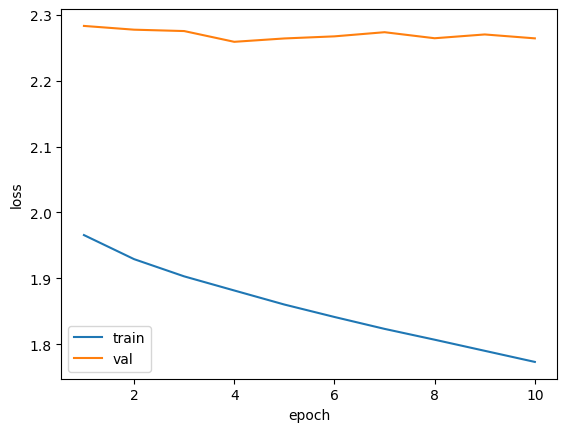

> verfolgten sie uns ?

= were we being followed ?

<  are you going to see us ? 

> als ich nach afghanistan zurückkehrte , war mein großvater , der , der von seiner familie verstoßen wurde , weil er es gewagt hat , seine töchter zur schule zu schicken , einer der ersten , der mir gratulierte .

= when i returned to afghanistan , my grandfather , the one exiled from his home for daring to educate his daughters , was among the first to congratulate me .

<  when i returned to afghanistan , my grandfather who was washed away by his family because he managed to send his daughters to school one of the first ones to me . 

> und ich entschied , es so in stand zu halten .

= and this is how i decided to maintain it .

<  and i decided to keep it like this . 

> so wie 26,5 millionen andere amerikaner lebe ich in der essens-wüste south central los angeles , das zuhause des drive-thrus und des drive-bys .

= just like 26.5 million other americans , i live in a food desert , south central los 

In [18]:
train(train_loader, val_loader, model, 40, vocab_de, vocab_en)

In [19]:
with open("test_preds_last.de-en.en", "w") as f:
    with open("/kaggle/input/translation/test1.de-en.de") as test_read:
        for line in test_read.readlines():
            translation = evaluate(model, line, vocab_de, vocab_en)
            f.write(translation + '\n')

model.load_state_dict(torch.load('/kaggle/working/transformer_best.pt'))

with open("test_preds_best.de-en.en", "w") as f:
    with open("/kaggle/input/translation/test1.de-en.de") as test_read:
        for line in test_read.readlines():
            translation = evaluate(model, line, vocab_de, vocab_en)
            f.write(translation + '\n')